In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.datasets import make_swiss_roll


class SwissRoll_Dataset(Dataset):
    def __init__(self, data_size = 10000, phase='test', use_2D_otherwise_3D = True):
        super(SwissRoll_Dataset, self).__init__()
        self.use_2D_otherwise_3D = use_2D_otherwise_3D

        data, _ = make_swiss_roll(n_samples=data_size, noise=0.3)

        if use_2D_otherwise_3D:
            # If 2D, select only the first and third columns (x and z axes).
            data = data[:, [0, 2]]/10
            data_dim = 2
        else:
            # If 3D, use all three columns.
            data_dim = 3

        # Initialize the dataset with zeros
        train_data = data.reshape(data_size, data_dim)

        self.inputs = train_data
        self.batch_size = 1_000_000
        if phase == 'train':
            self.size = int(90.0 / 100.0 * len(self.inputs))
            self.data = self.inputs[:self.size]
        elif phase == 'test':
            self.size = int(10.0 / 100.0 * len(self.inputs))
            self.data = self.inputs[self.size:]
    
    
    def __len__(self):
        return self.size

    def __iter__(self):
        return self

    def __getitem__(self, index):
        
        return self.data[index]

In [2]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
import torch

device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.01, "beta_max": 2},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        # if clip_denoised and x_t.ndim > 2:
        #     print('backward_one_step')
        #     x_prev.clamp_(-1., 1.)

        return x_prev
    
    def backward_k_step(self, x_t, t, step, net, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        for i in range(step):
            z = torch.randn_like(x_t).to(device)
            pred_score = net(x_t, t)
            f_t, g_t = self.sde.drifts(x_t, t)
            f_t = f_t.to(device)
            x_t = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
            t = t - 1
            # if clip_denoised and x_t.ndim > 2:
            #     print('backward_one_step')
            #     x_t.clamp_(-1., 1.)

        return x_t

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.stack(trajs,1)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1,data.shape[1]])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def q_step_backward_sample(self, noise, net, step, end_t):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(end_t-step+2, end_t+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.stack(trajs,1)
    

    def backward_sample_example(self, forward_process, net, skip_step=1):
        """
        Sample from backward diffusion process
        forward_process: torch.tensor, shape=[num_paths, T]
        """
        forward_end = forward_process[:, -1]
        backward_trajs = []
        forward_trajs = []
        backward_trajs.append(forward_end.unsqueeze(1))
        forward_trajs.append(forward_end.unsqueeze(1))
        for t in range(self.total_steps, skip_step-1, -skip_step):
            x_t = self.backward_k_step(forward_process[:,t].unsqueeze(1), t, skip_step, net)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,t-skip_step].unsqueeze(1))
        left_steps = t - skip_step
        while left_steps > 0:
            pred_score = net(forward_process[:,left_steps].unsqueeze(1), left_steps)
            x_t = self.backward_one_step(x_t, left_steps, pred_score)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,left_steps-1].unsqueeze(1)) 
            left_steps -= 1
        forward_trajs = torch.stack(forward_trajs, dim=1)
        backward_trajs = torch.stack(backward_trajs,dim=1)
        return x_t, forward_trajs, backward_trajs 

            



In [3]:
score_net = ToyNet(data_dim=2).to(device)
total_steps = 100

diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 2, add_time=True).to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)

In [4]:
import torch.nn.functional as F
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [5]:
train_batch_size = 256
num_worker = 8

train_data_loader = torch.utils.data.DataLoader(
            dataset=SwissRoll_Dataset(data_size = 10000, phase='train', use_2D_otherwise_3D = True),
            batch_size = train_batch_size,
            shuffle=True,
            num_workers= num_worker,
            drop_last=True,
            worker_init_fn=init_seed)


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]


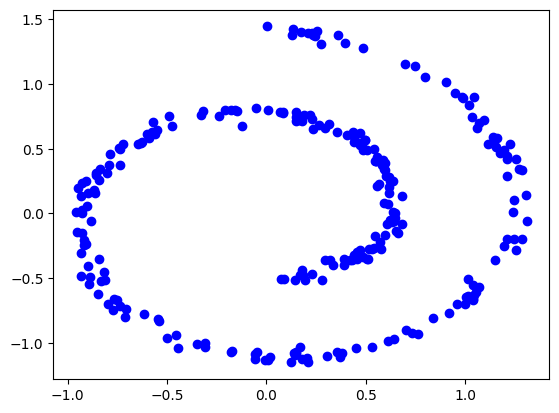

In [6]:
plt.figure()
for forward_bacth in tqdm(train_data_loader, dynamic_ncols=True):
    plt.scatter(
                forward_bacth[:,  0],
                forward_bacth[:,  1],
                c="b",
                label="Train Data",
            )
    break

  0%|          | 0/35 [00:00<?, ?it/s]

torch.Size([256, 101, 2])


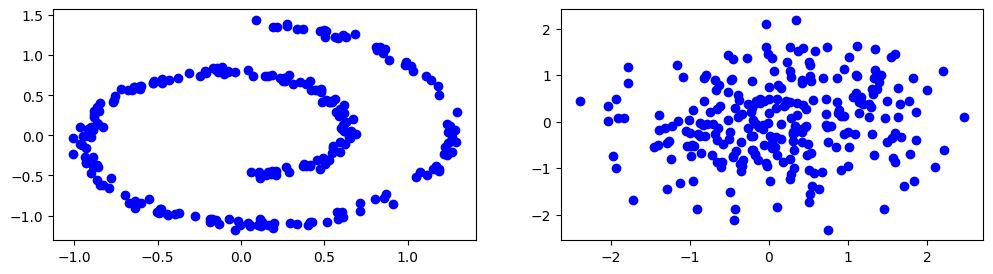

In [7]:
for forward_bacth in tqdm(train_data_loader, dynamic_ncols=True):
        plt.figure(figsize=(12,3))
        plt.subplot(1, 2, 1)
        x_noise, traj_forward = diffusion.forward_sample(forward_bacth)
        print(traj_forward.shape)
        # traj_forward = traj_forward.to(device)
        plt.scatter(
                forward_bacth[:,  0],
                forward_bacth[:,  1],
                c="b",
                label="Train Data",
            )
        
        plt.subplot(1, 2, 2)
        plt.scatter(
                traj_forward[:,  -1, 0],
                traj_forward[:,  -1, 1],
                c="b",
                label="Train Data",
            )
        break

  0%|          | 0/35 [00:01<?, ?it/s]


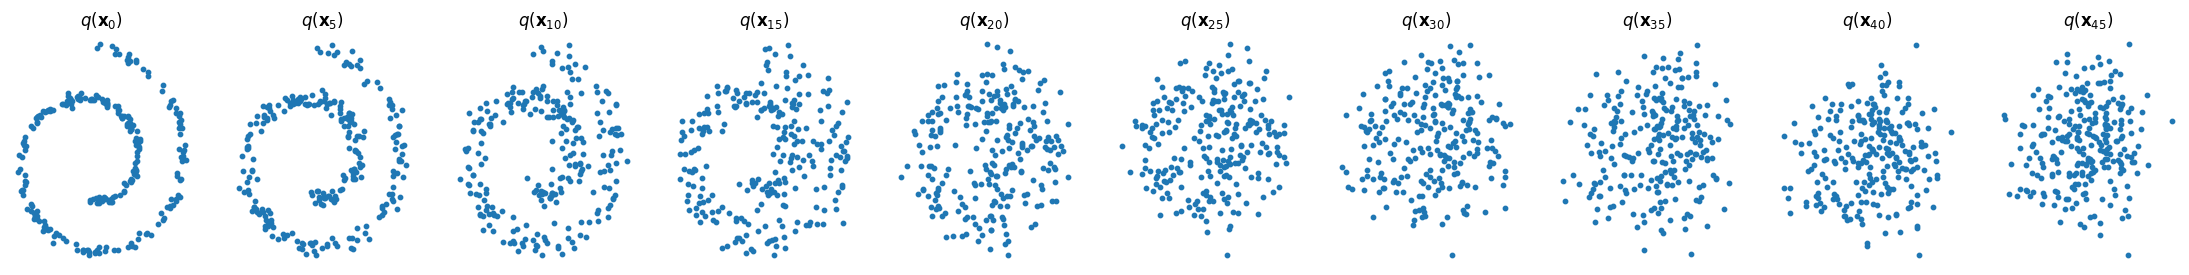

In [8]:
for forward_bacth in tqdm(train_data_loader, dynamic_ncols=True):
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    x_noise, traj_forward = diffusion.forward_sample(forward_bacth)
    for i in range(10):        
        axs[i].scatter(traj_forward[:,i*5, 0], traj_forward[:,i*5, 1], s=10)
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*5)+'})$')

    break

traing for score matching loss + 5-step pcfd loss

0 -0.061382558196783066 0.06957057118415833


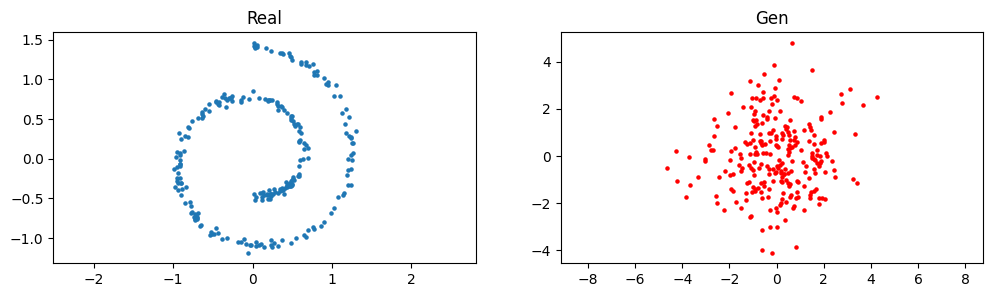

50 -0.04377200827002525 0.04637622833251953


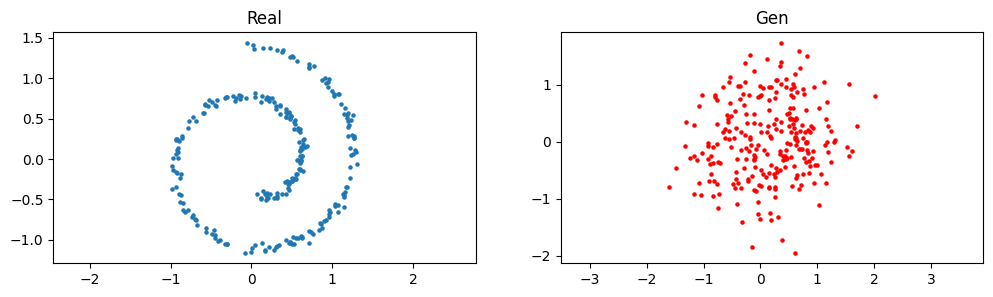

100 -0.06042717769742012 0.046924300491809845


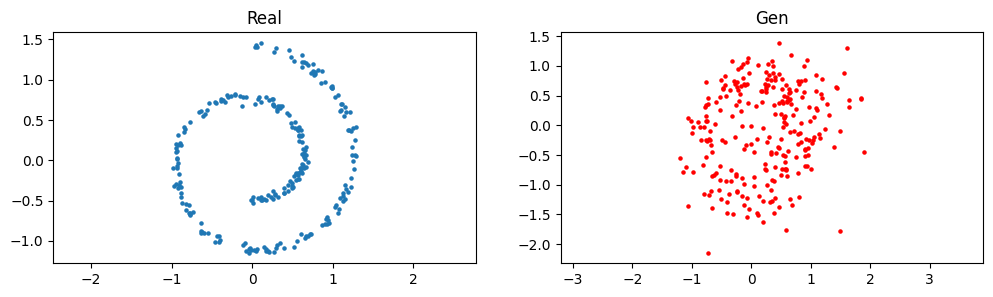

150 -0.06975530087947845 0.06265323609113693


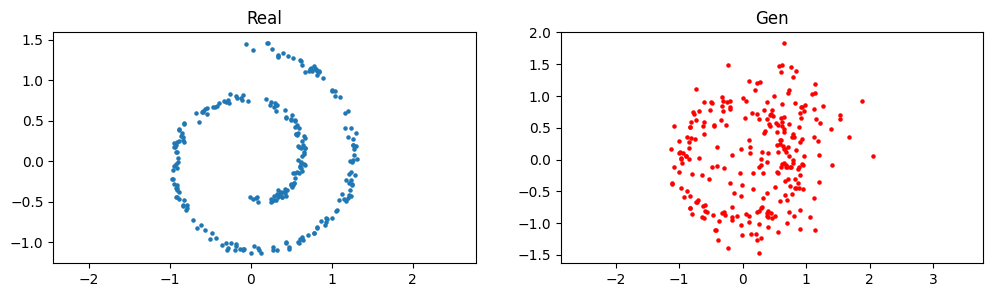

200 -0.03928913548588753 0.05147671699523926


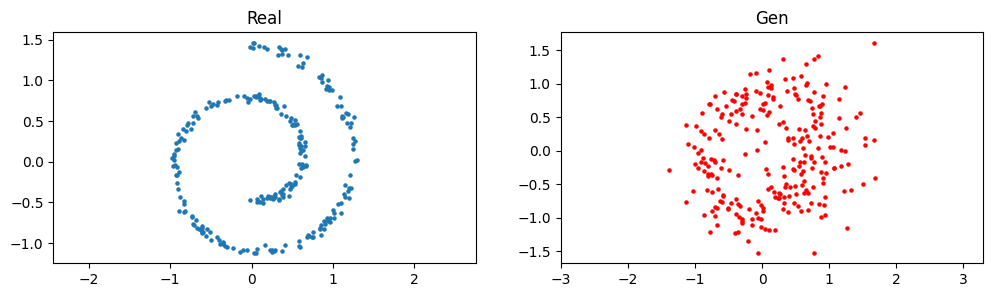

250 -0.044533178210258484 0.05493718758225441


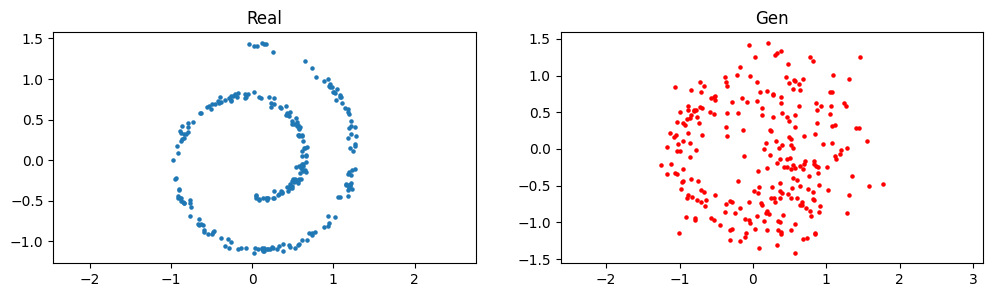

300 -0.06406712532043457 0.06219515576958656


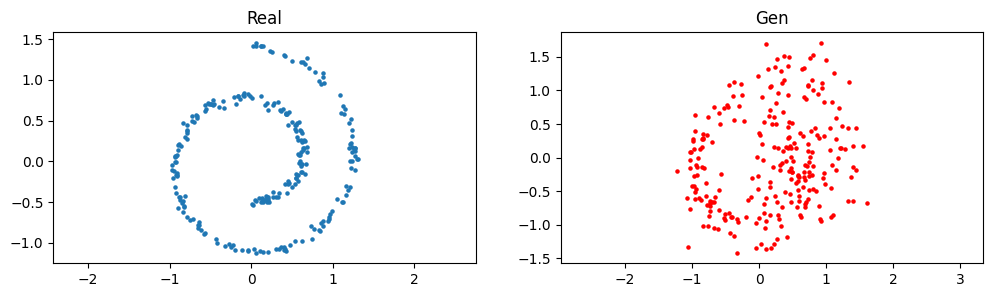

350 -0.07174678146839142 0.06645753979682922


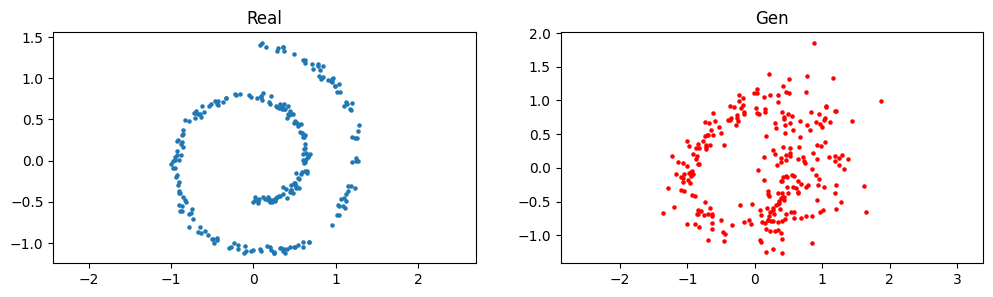

400 -0.08143721520900726 0.06577203422784805


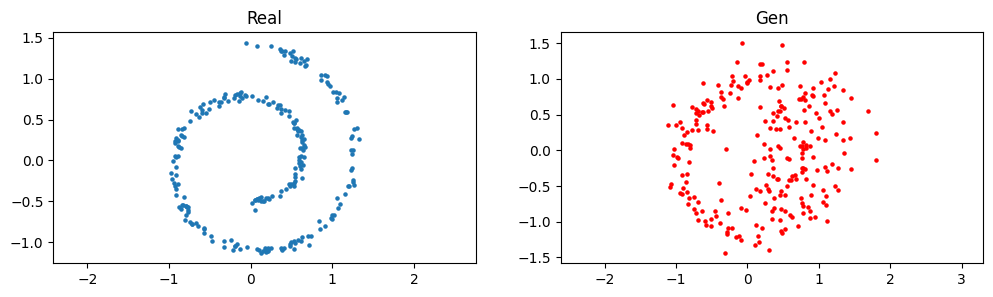

450 -0.03658045083284378 0.041569411754608154


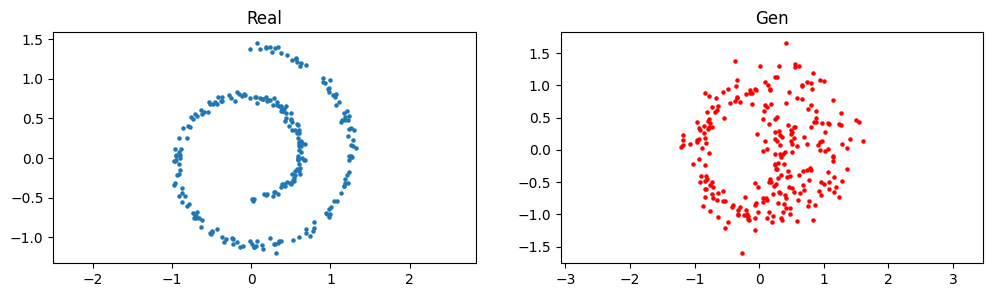

500 -0.051036298274993896 0.04869842901825905


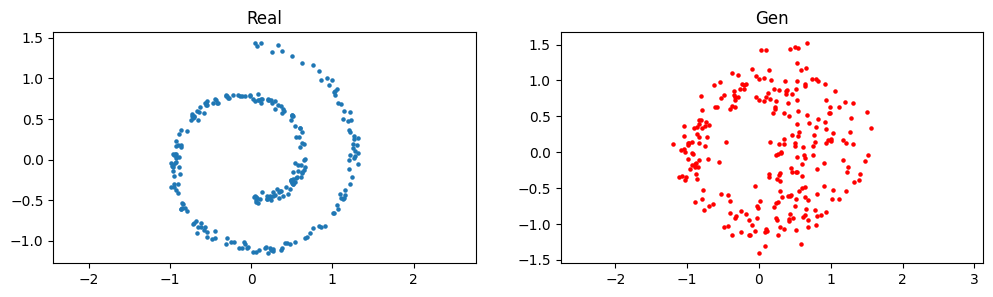

550 -0.055133089423179626 0.06635123491287231


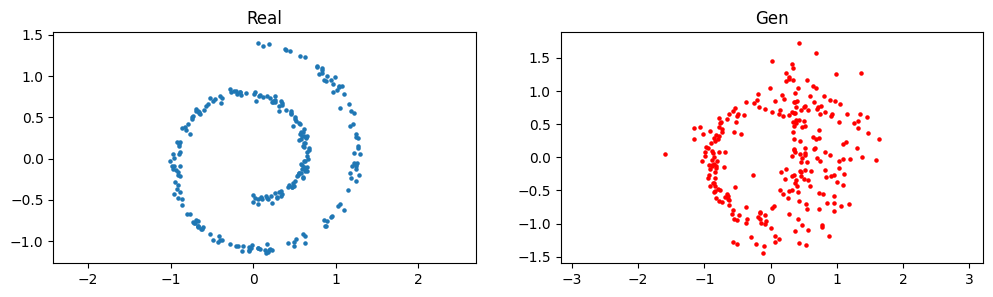

600 -0.0607457160949707 0.047438159584999084


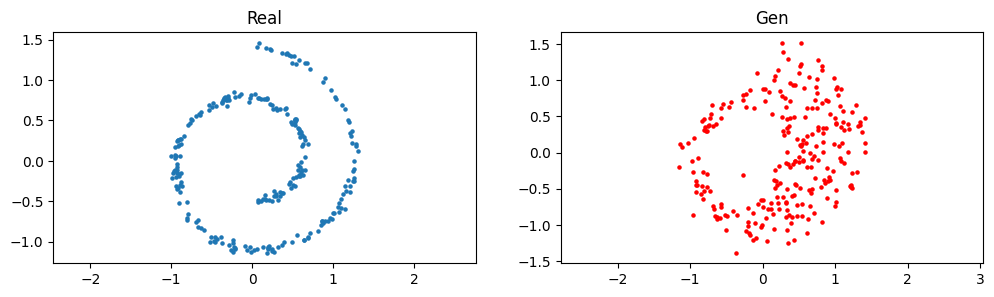

650 -0.07453708350658417 0.08113358914852142


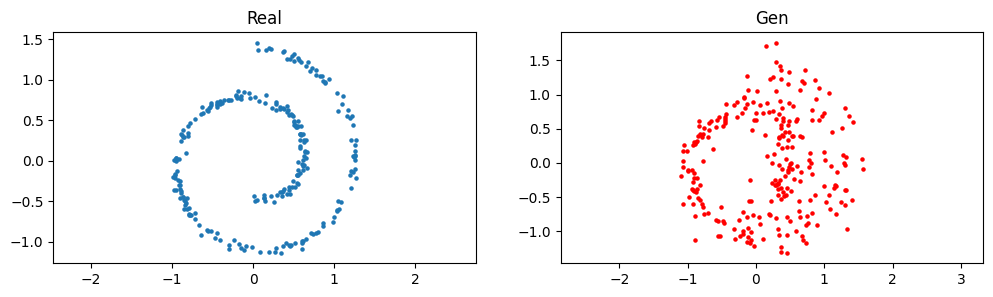

700 -0.06945198029279709 0.085980124771595


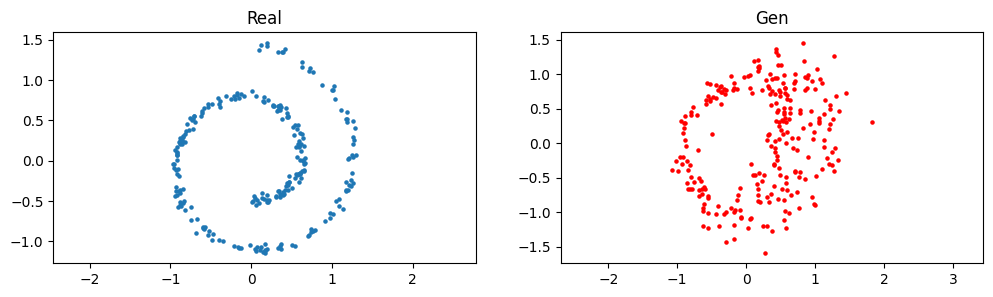

750 -0.07349417358636856 0.08061415702104568


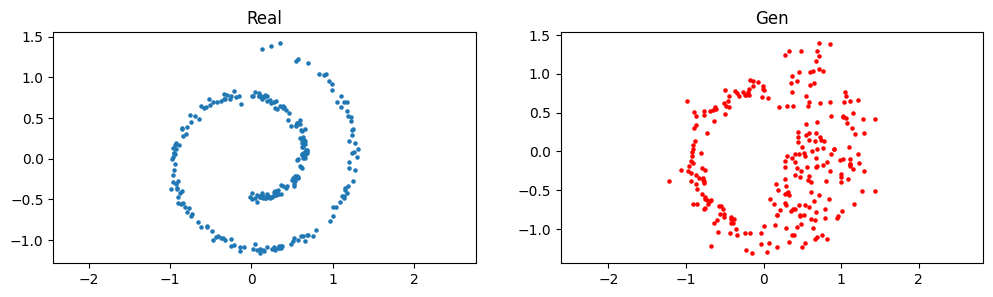

800 -0.07455167174339294 0.07498732954263687


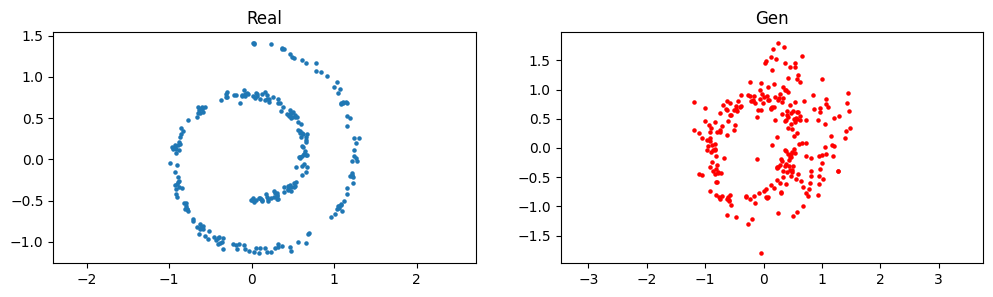

850 -0.07374301552772522 0.07338851690292358


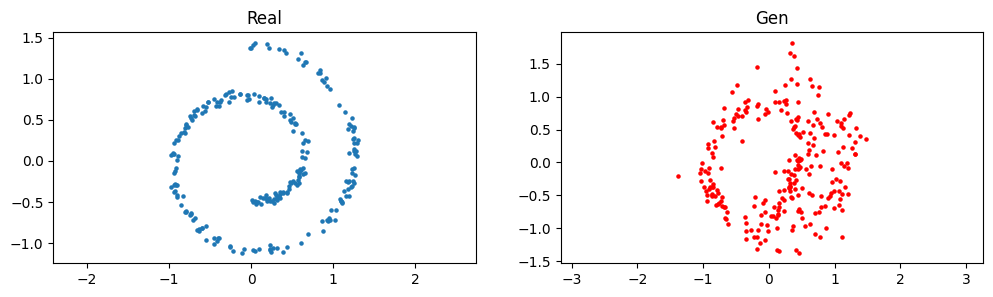

900 -0.07042503356933594 0.07728658616542816


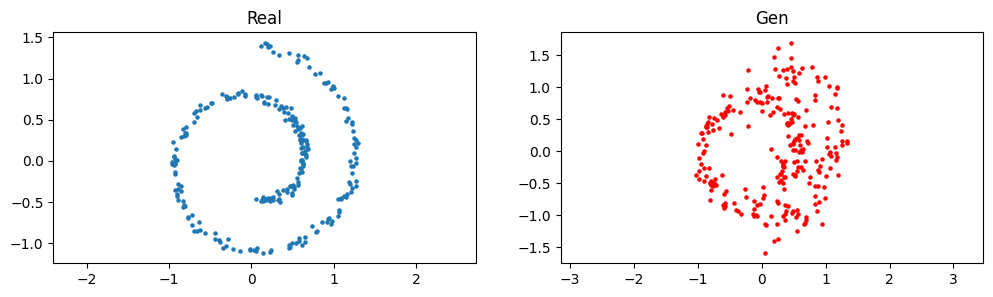

950 -0.07386206835508347 0.07158179581165314


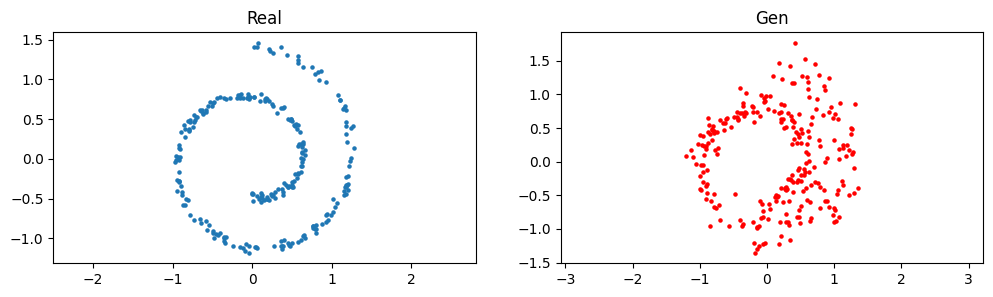

1000 -0.07473647594451904 0.07938849925994873


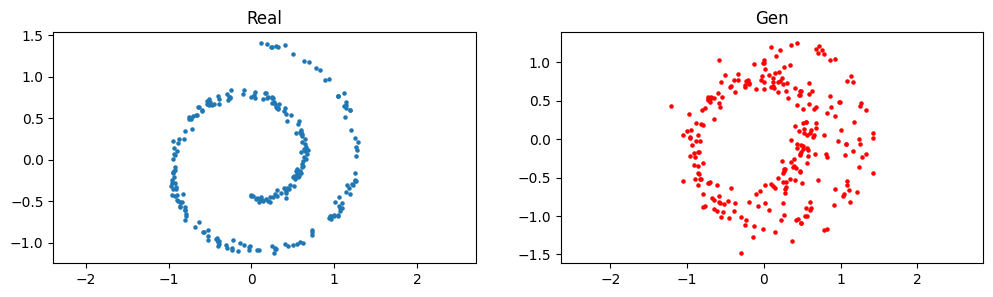

1050 -0.062066882848739624 0.06537541002035141


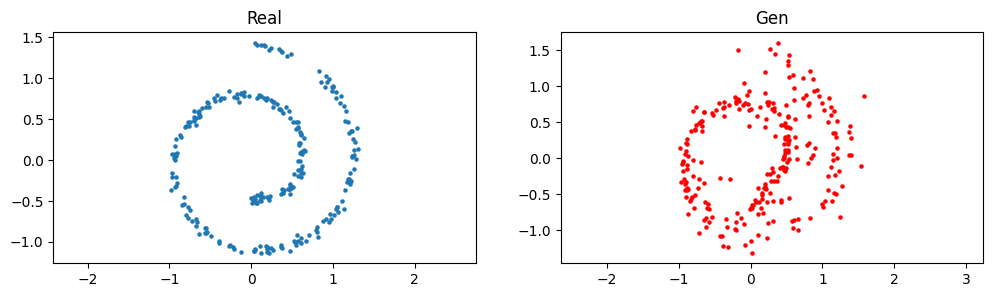

1100 -0.08228082954883575 0.0781044214963913


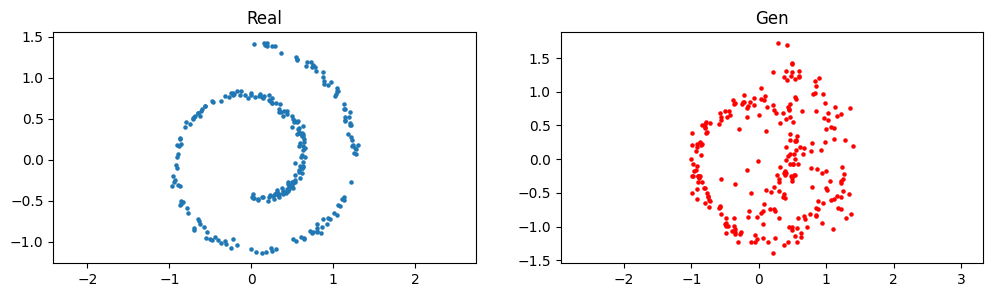

1150 -0.07242238521575928 0.0751185491681099


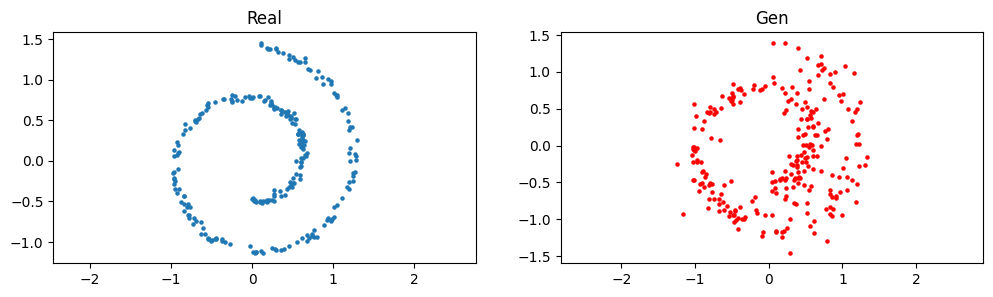

1200 -0.06976057589054108 0.06758914887905121


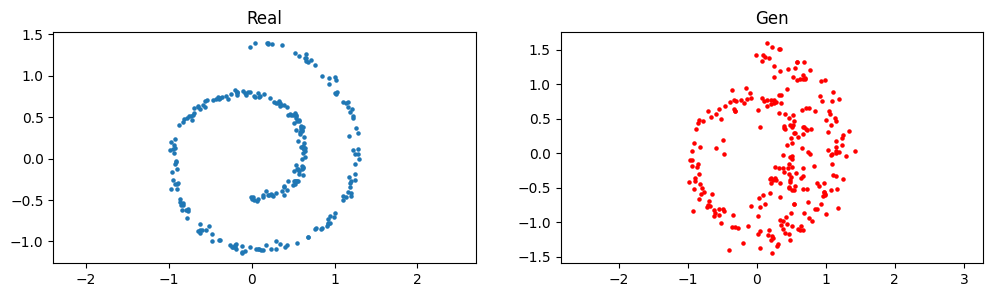

1250 -0.08302447199821472 0.06951659917831421


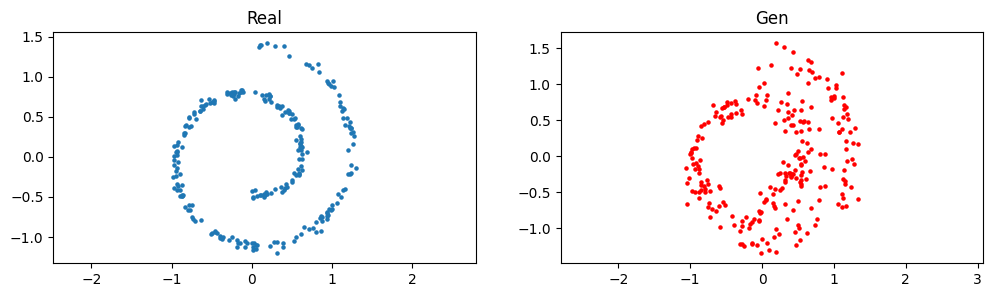

1300 -0.07899264991283417 0.0682523101568222


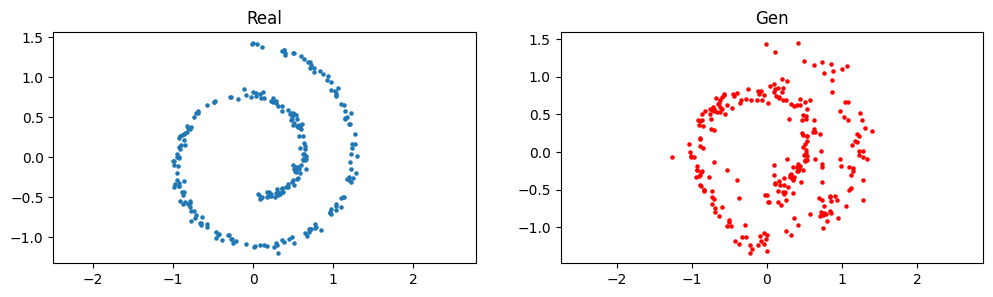

1350 -0.0791955441236496 0.08890801668167114


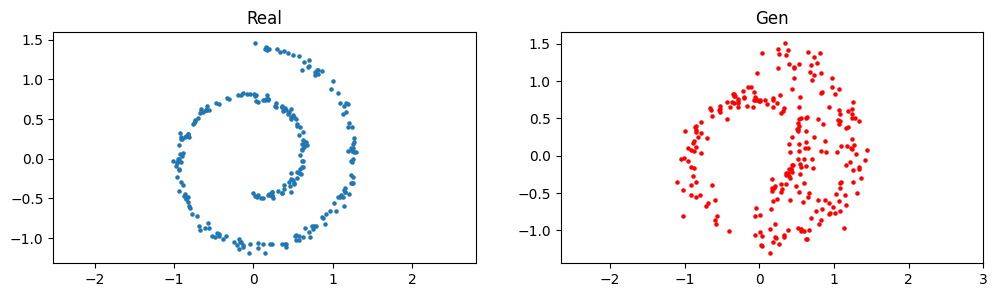

1400 -0.07344473153352737 0.07468266785144806


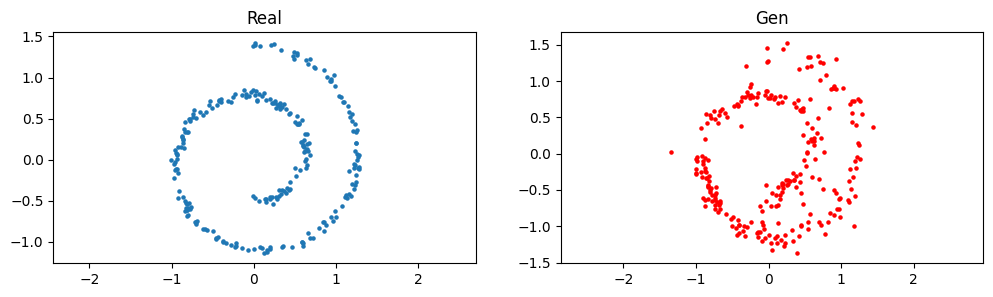

1450 -0.07988393306732178 0.07244586944580078


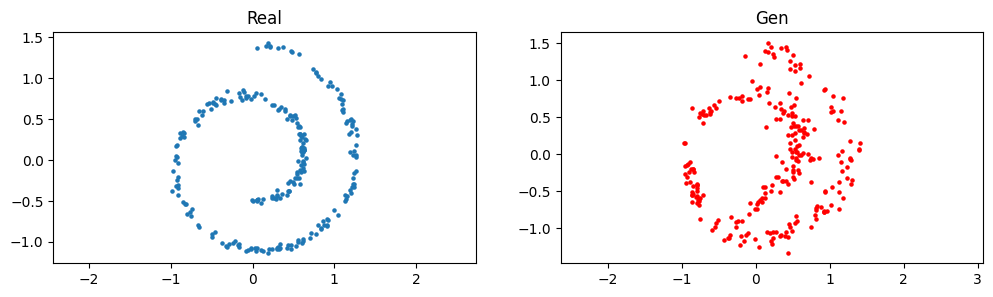

1500 -0.07779568433761597 0.06989578157663345


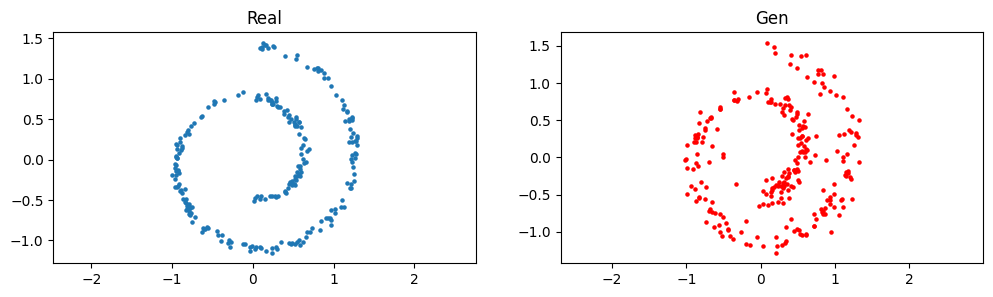

1550 -0.08134545385837555 0.07377098500728607


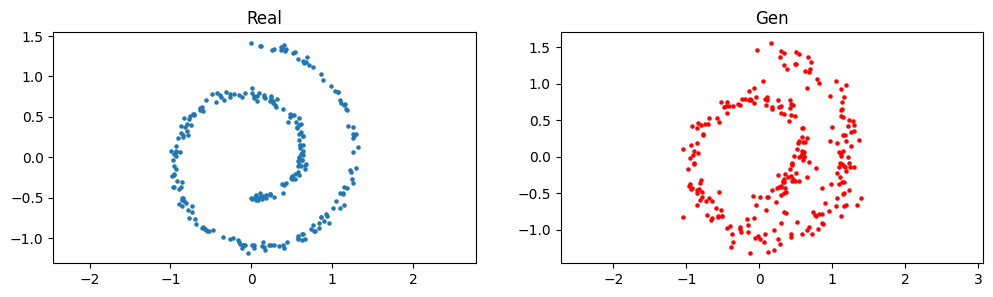

1600 -0.051970724016427994 0.052496422082185745


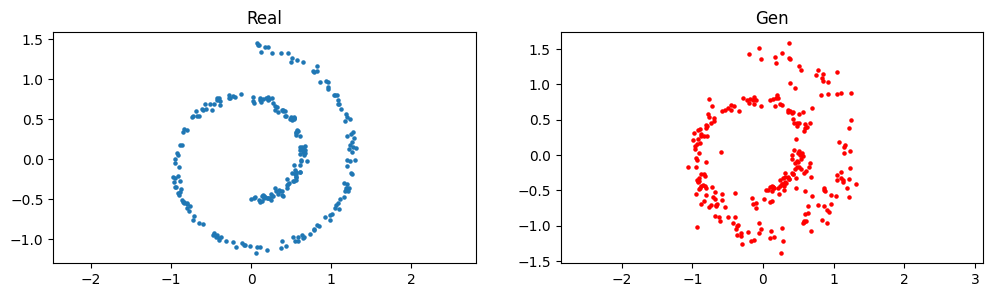

1650 -0.0748925507068634 0.06383930146694183


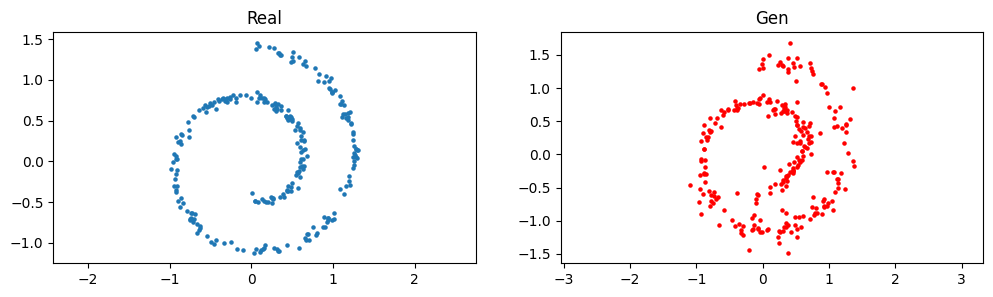

1700 -0.07673381268978119 0.07643018662929535


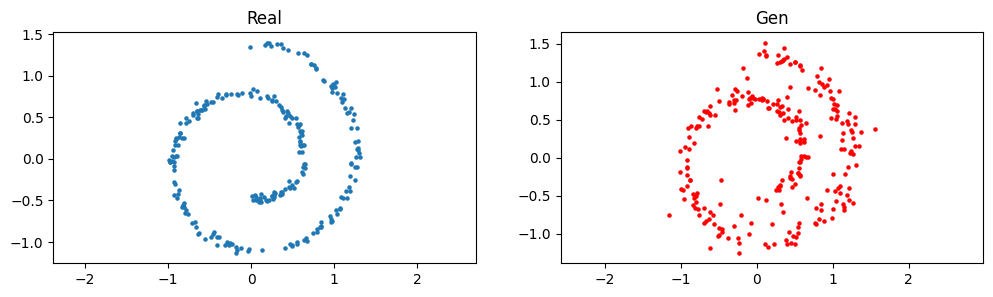

1750 -0.0789283886551857 0.07848987728357315


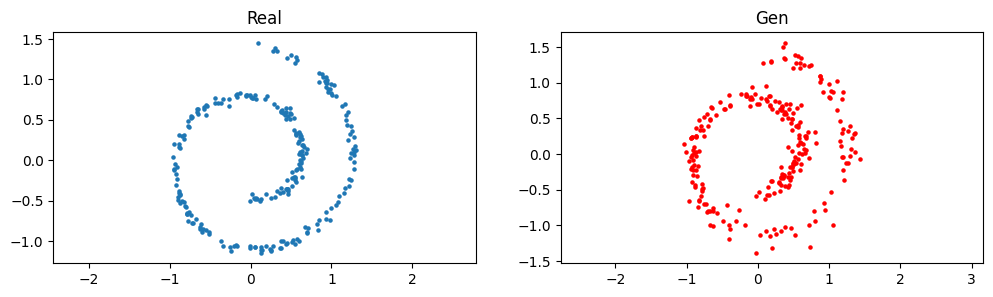

1800 -0.08341960608959198 0.0872143879532814


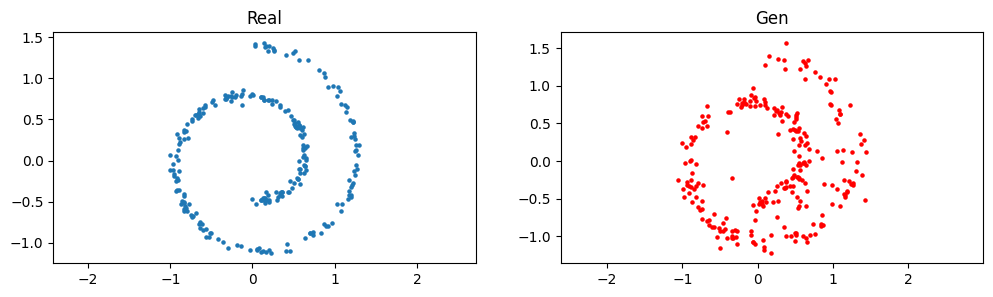

1850 -0.06925253570079803 0.06676974147558212


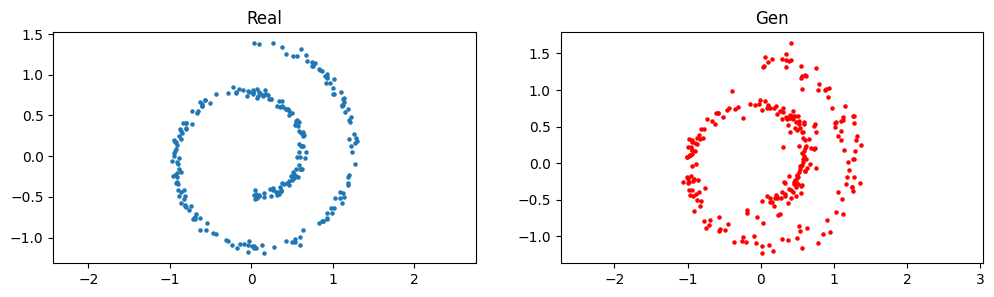

1900 -0.07251367717981339 0.061954647302627563


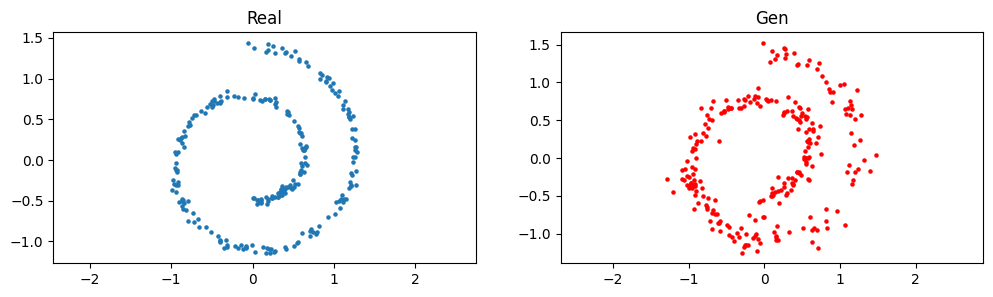

1950 -0.081556037068367 0.07818737626075745


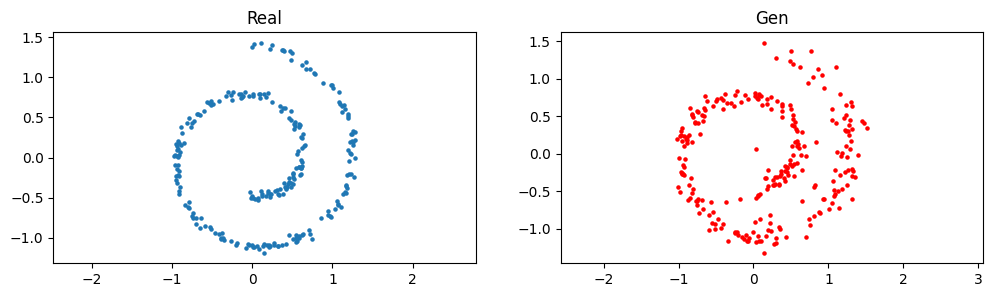

2000 -0.061713479459285736 0.05661986768245697


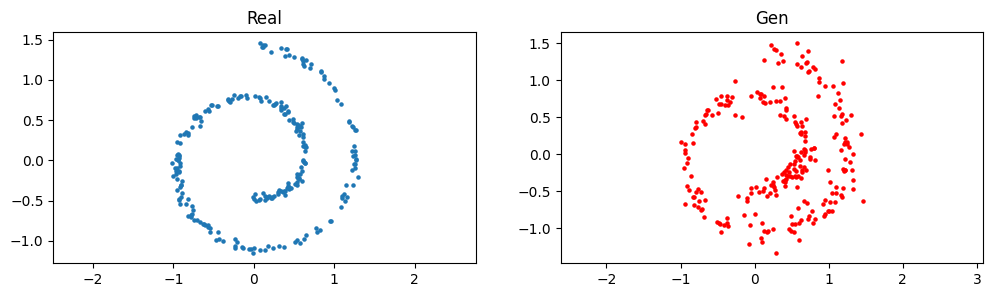

In [9]:
def plot_x_gen(x_real, x_gen):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, alpha=1.0)
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    #plt.ylabel(f't={t}')
    plt.title('Real')
        
    plt.subplot(1, 2, 2)
    plt.scatter(x_gen[:, 0], x_gen[:, 1], s=5, alpha=1.0, color='r')
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    plt.title('Gen')
    plt.show()

num_epochs = 2001

for i in range(num_epochs):

    # x_data = data_dist.sample([num_paths]
    for forward_bacth in train_data_loader:
        x_noise, traj_forward = diffusion.forward_sample(forward_bacth)
        traj_forward = traj_forward.to(device)
            
        q_step = 15
        t_sample = torch.randint(q_step, total_steps+1, (1,)).item()
        
        # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
        # So we train the PCF to maxmise the distance between the real data and the generated data.
        with torch.no_grad():
            x_gen, traj_back = diffusion.q_step_backward_sample(traj_forward[:,t_sample], score_net,q_step,t_sample)
            traj_forward_flip = torch.fliplr(traj_forward[:,t_sample-q_step+1:t_sample+1])

        pcf.train()

        D_loss = -pcf.distance_measure(traj_forward_flip.view([-1, q_step, 2]), traj_back.view([-1, q_step, 2]), Lambda=1.0)

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
    
        # train the score network to minmise the distance between the real data and the generated data
        x_gen1, traj_back1 = diffusion.q_step_backward_sample(traj_forward[:,t_sample], score_net,q_step,t_sample)
        
        pcf.eval()
        
        G_loss =  pcf.distance_measure(traj_forward_flip.view([-1, q_step, 2]), traj_back1.view([-1, q_step, 2]), Lambda=1.0) 
            
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
    if i % 50 == 0:
        print(i, D_loss.item() , G_loss.item())
        x_gen, traj_back = diffusion.sample(torch.randn([train_batch_size, 2]).to(device), score_net)
        plot_x_gen(forward_bacth, x_gen.detach().cpu())
        

In [10]:
test_batch_size = 200
num_worker = 8
test_data_loader = torch.utils.data.DataLoader(
            dataset=SwissRoll_Dataset(data_size = 10000, phase='test', use_2D_otherwise_3D = True),
            batch_size = test_batch_size,
            shuffle=False,
            num_workers= num_worker,
            drop_last=False,
            worker_init_fn=init_seed)


  0%|          | 0/5 [00:01<?, ?it/s]


<Figure size 640x480 with 0 Axes>

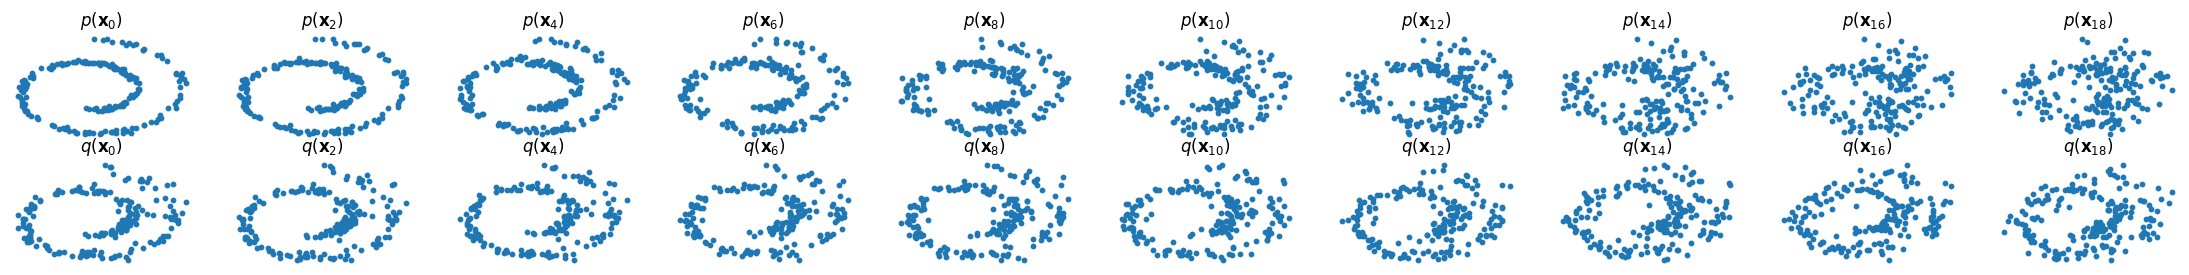

In [11]:

plt.figure()
for test_example in tqdm(test_data_loader, dynamic_ncols=True):
    fig, axs = plt.subplots(2, 10, figsize=(28, 3))
    x_noise, traj_forward = diffusion.forward_sample(test_example)
    for i in range(10):
        axs[0,i].scatter(traj_forward[:,i*2, 0], traj_forward[:,i*2, 1], s=10)
        axs[0,i].set_axis_off(); axs[0,i].set_title('$p(\mathbf{x}_{'+str(i*2)+'})$')

    noise = torch.randn(x_noise.shape).to(device)
    x_gen, traj_back = diffusion.sample(noise.float(), score_net)
    x_gen = x_gen.cpu().detach().numpy()    
    traj_back = torch.fliplr(traj_back).cpu().detach().numpy()

    for i in range(10):
        axs[1,i].scatter(traj_back[:,i*2, 0], traj_back[:,i*2, 1], s=10)
        axs[1,i].set_axis_off(); axs[1,i].set_title('$q(\mathbf{x}_{'+str(i*2)+'})$')
    
    break




  0%|          | 0/5 [00:00<?, ?it/s]

(200, 2)


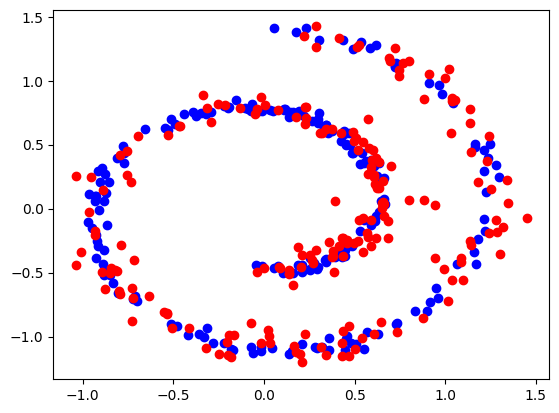

In [12]:
plt.figure()
for test_example in tqdm(test_data_loader, dynamic_ncols=True):    
    plt.scatter(
                test_example[:,  0],
                test_example[:,  1],
                c="b",
                label="Test Data",
            )
    x_noise, traj_forward = diffusion.forward_sample(test_example)
    noise = torch.randn(x_noise.shape).to(device)
    x_gen, traj_back = diffusion.sample(noise.float(), score_net)
    x_gen = x_gen.cpu().detach().numpy()
    print(x_gen.shape)
    plt.scatter(
                x_gen[:, 0],
                x_gen[:, 1],
                c="r",
                label="Generated Data",
            )
    break

In [13]:
torch.save(score_net.state_dict(), './score_net_corrected_15steps_swiss_epoch2000.pt')
torch.save(pcf.state_dict(), './pcf_corrected_15steps_swiss_epoch2000.pt')